# Overview of the omics dataset

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2


### Load omics data

In [54]:
rna = pandas.read_csv("./datasets/omics/RNA-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [55]:
ribo = pandas.read_csv("./datasets/omics/RS-counts.csv",sep=',',index_col=0)[["PPutida_1","PPutida_2","PPutida_4"]]

In [56]:
# Annotation = pandas.read_csv("./GeneAnnotation.csv",index_col=0).dropna(subset="subsystem")

In [57]:
Results = ribo.join(rna,rsuffix="_rna")
# Results = Results.loc[set(Annotation.index) & set(Results.index)]
Results.head()

,PPutida_1,PPutida_2,PPutida_4,PPutida_1_rna,PPutida_2_rna,PPutida_4_rna
PP_0001,4404,4187,2165,64.0,185.0,203.0
PP_0010,24817,27045,10591,130.0,329.0,274.0
PP_0097,790,615,401,8.0,58.0,47.0
PP_0947,1253,1395,735,13.0,21.0,20.0
PP_0948,539,585,541,7.0,16.0,16.0


### Combine results

In [58]:
ResultsLog = numpy.log10(Results).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()
samples = ["PPutida_1","PPutida_2","PPutida_4"]
rna_samples = [s+"_rna" for s in samples]
colors = ["#2b83ba","#66bd63","#fdae61"]

/opt/miniconda3/envs/coralme-1.1.5/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [59]:
NormalizedRibo = ribo.div(ribo.sum())*1e6
NormalizedRNA = rna.div(rna.sum())*1e6
ResultsCPM = pandas.concat([NormalizedRibo,NormalizedRNA.rename(columns={s:s+"_rna" for s in samples})],axis=1).dropna()
ResultsLogCPM = numpy.log10(ResultsCPM).replace([numpy.inf, -numpy.inf], numpy.nan, inplace=False).dropna()

/opt/miniconda3/envs/coralme-1.1.5/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [60]:
import seaborn as sns

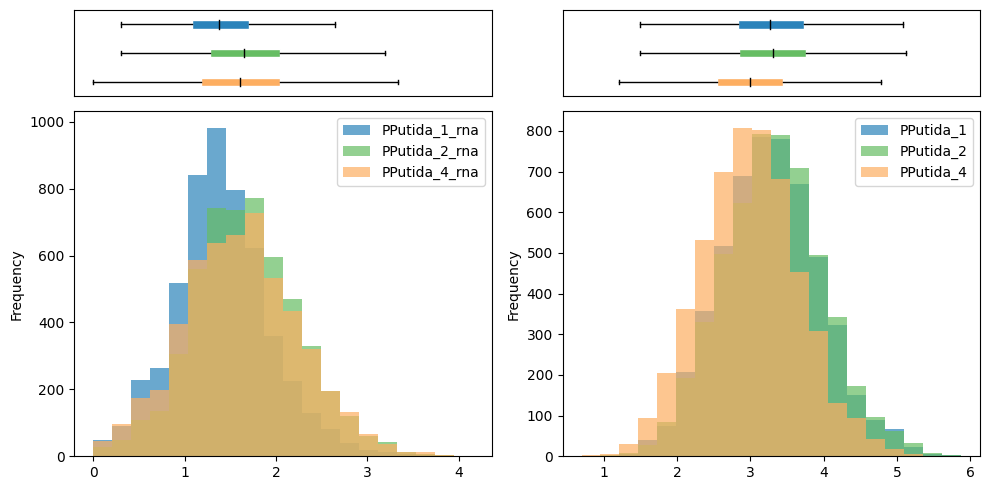

In [61]:
import matplotlib.ticker as ticker
alpha = 0.7
fig,ax = plt.subplots(2,2,figsize=(10,5),gridspec_kw={'height_ratios': [1,4]})
_,props = ResultsLog[rna_samples[::-1]].plot.box(vert=False,ax=ax[0,0],patch_artist=True,return_type='both',color="black", flierprops={'markersize': 0})
for patch,color in zip(props['boxes'],colors[::-1]):
    patch.set_facecolor(color)
    patch.set_edgecolor("white")
ResultsLog[rna_samples].plot.hist(alpha=alpha,bins=20,ax=ax[1,0],color=colors)
_,props = ResultsLog[samples[::-1]].plot.box(vert=False,ax=ax[0,1],patch_artist=True,return_type='both',color="black", flierprops={'markersize': 0})
for patch,color in zip(props['boxes'],colors[::-1]):
    patch.set_facecolor(color)
    patch.set_edgecolor("white")
    
ResultsLog[samples].plot.hist(alpha=alpha,bins=20,ax=ax[1,1],color=colors)

ax[0,0].xaxis.set_major_locator(ticker.NullLocator())
ax[0,0].yaxis.set_major_locator(ticker.NullLocator())
ax[0,1].xaxis.set_major_locator(ticker.NullLocator())
ax[0,1].yaxis.set_major_locator(ticker.NullLocator())

# for a in ax[:,0]:
#     a.set_xlim([-1,5])

# for a in ax[:,1]:
#     a.set_xlim([1,6])

fig.tight_layout()
fig.savefig("./figures/omics-distributions.svg")

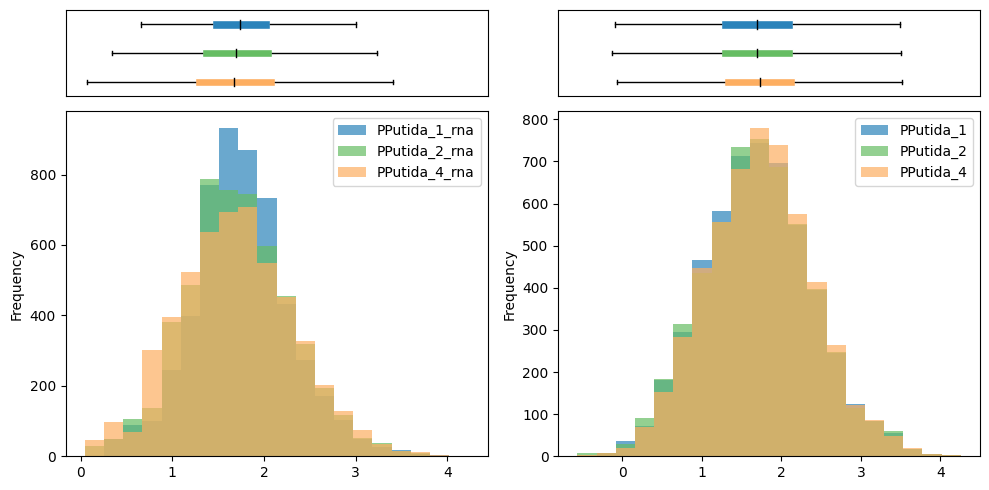

In [76]:
import matplotlib.ticker as ticker
alpha = 0.7
fig,ax = plt.subplots(2,2,figsize=(10,5),gridspec_kw={'height_ratios': [1,4]})
_,props = ResultsLogCPM[rna_samples[::-1]].plot.box(vert=False,ax=ax[0,0],patch_artist=True,return_type='both',color="black", flierprops={'markersize': 0})
for patch,color in zip(props['boxes'],colors[::-1]):
    patch.set_facecolor(color)
    patch.set_edgecolor("white")
ResultsLogCPM[rna_samples].plot.hist(alpha=alpha,bins=20,ax=ax[1,0],color=colors)
_,props = ResultsLogCPM[samples[::-1]].plot.box(vert=False,ax=ax[0,1],patch_artist=True,return_type='both',color="black", flierprops={'markersize': 0})
for patch,color in zip(props['boxes'],colors[::-1]):
    patch.set_facecolor(color)
    patch.set_edgecolor("white")
    
ResultsLogCPM[samples].plot.hist(alpha=alpha,bins=20,ax=ax[1,1],color=colors)

ax[0,0].xaxis.set_major_locator(ticker.NullLocator())
ax[0,0].yaxis.set_major_locator(ticker.NullLocator())
ax[0,1].xaxis.set_major_locator(ticker.NullLocator())
ax[0,1].yaxis.set_major_locator(ticker.NullLocator())

# for a in ax[:,0]:
#     a.set_xlim([-1,5])

# for a in ax[:,1]:
#     a.set_xlim([1,6])

fig.tight_layout()
fig.savefig("./figures/omics-distributions-CPM.svg")

### Comparing

In [62]:
from scipy.stats import ttest_ind,pearsonr
def ttest(slist):
    # slist = samples
    dct = {}
    for i in slist:
        dct[i] = {}
        for j in slist:
            dct[i][j] = ttest_ind(ResultsCPM[i],ResultsCPM[j],alternative="two-sided").pvalue
    return pandas.DataFrame.from_dict(dct)

def pearson(slist):
    # slist = samples
    dct = {}
    for i in slist:
        dct[i] = {}
        for j in slist:
            dct[i][j] = pearsonr(ResultsCPM[i],ResultsCPM[j],alternative="two-sided")[0]
    return pandas.DataFrame.from_dict(dct)

In [63]:
import seaborn as sns

### RNA

/tmp/ipykernel_198205/1798156381.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


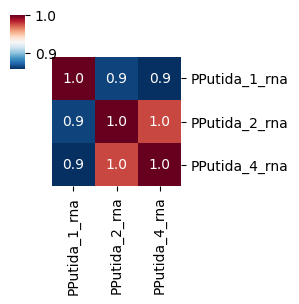

In [77]:
cmap_df = pearson(rna_samples)
cmap = plt.cm.get_cmap('RdBu_r').copy()
cmap.set_under('white')
# vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=False,
               col_cluster=False,
               # vmin=vmin,
               # vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(3,3),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
plt.savefig("./figures/rna-seq-pcc.svg",format="svg")

/tmp/ipykernel_198205/2868038568.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


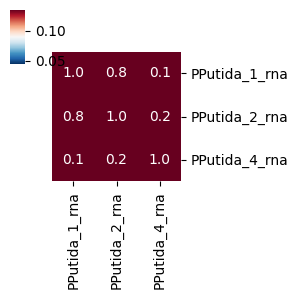

In [78]:
cmap_df = ttest(rna_samples)
cmap = plt.cm.get_cmap('RdBu_r').copy()
cmap.set_under('white')
# vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=False,
               col_cluster=False,
               # vmin=vmin,
               vmax=0.05,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(3,3),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
plt.savefig("./figures/rna-seq-mean-different.svg",format="svg")

### Ribo

/tmp/ipykernel_198205/3260118054.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


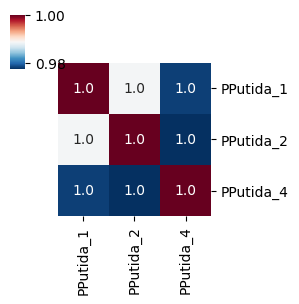

In [79]:
cmap_df = pearson(samples)
cmap = plt.cm.get_cmap('RdBu_r').copy()
cmap.set_under('white')
# vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=False,
               col_cluster=False,
               # vmin=vmin,
               # vmax=vmax,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(3,3),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
plt.savefig("./figures/ribo-seq-pcc.svg",format="svg")

/tmp/ipykernel_198205/89164761.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


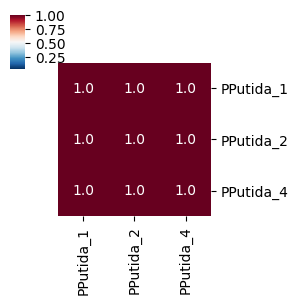

In [80]:
cmap_df = ttest(samples)
cmap = plt.cm.get_cmap('RdBu_r').copy()
cmap.set_under('white')
# vmin,vmax = (1.0,2)
cmap = sns.clustermap(cmap_df,
               row_cluster=False,
               col_cluster=False,
               # vmin=vmin,
               vmax=0.05,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               # annot_kws={'rotation': 90}
               figsize=(3,3),
               # cbar=False,
              )
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
plt.savefig("./figures/ribo-seq-mean-different.svg",format="svg")

In [66]:
import statsmodels.api as sm
from scipy import stats
from scipy.stats import pearsonr

0.41281070459497304 PearsonRResult(statistic=0.6425034666015219, pvalue=0.0)
0.7153880452941582 PearsonRResult(statistic=0.8458061511328456, pvalue=0.0)
0.7385353568612361 PearsonRResult(statistic=0.8593807985178841, pvalue=0.0)


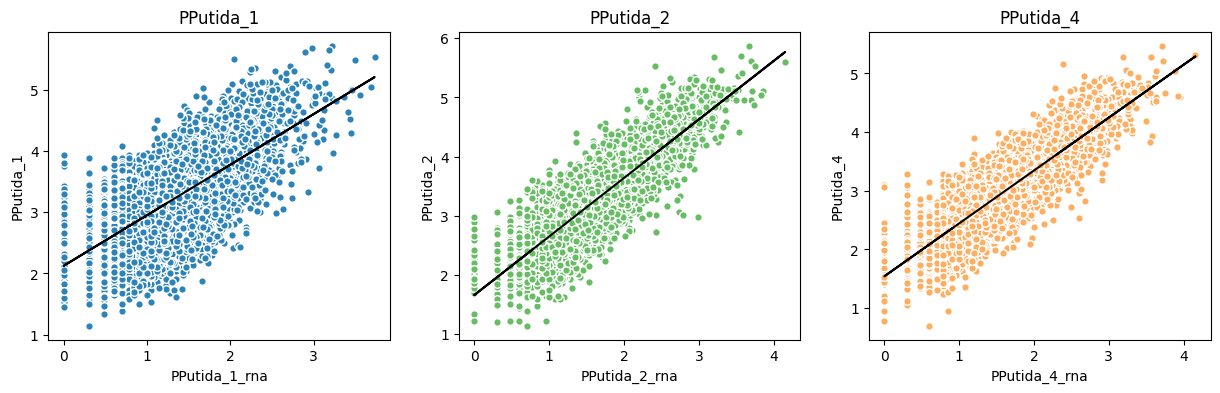

In [67]:
fig,ax = plt.subplots(1,3,figsize=(15,4))
for s,a,c in zip(samples,ax,colors):
    rna = s+"_rna"
    X = ResultsLog[rna].values
    y = ResultsLog[s].values
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    # print(est2.summary())
    print(est2.rsquared,pearsonr(y,est2.predict()))
    ResultsLog.plot.scatter(x=rna,y=s,ax=a,color=c,edgecolors='white',s=30)
    a.plot(X,est2.predict(),color="black")
    a.set_title(s)
fig.savefig("./figures/sample-rna-vs-ribo.svg")

0.6151737298677618 PearsonRResult(statistic=0.7843301153645457, pvalue=0.0)


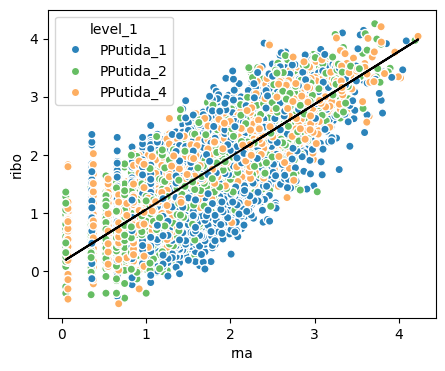

<Figure size 800x600 with 0 Axes>

In [136]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
X = []
y = []
for s,c in zip(samples,colors):
    rna = s+"_rna"
    for i in ResultsLogCPM[rna].values:
        X.append(i)
    for i in ResultsLogCPM[s].values:
        y.append(i)
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
# print(est2.summary())
print(est2.rsquared,pearsonr(y,est2.predict()))
df = pandas.concat([ResultsLogCPM[samples].stack(),
               ResultsLogCPM[rna_samples].rename(columns={s:s.split("_rna")[0] for s in rna_samples}).stack()],
              axis=1).rename(columns={0:"ribo",1:"rna"})


# Plot Scatter plot
custom_palette = {s:c for s,c in zip(samples,colors)}
# Reset index to access the second index
df_reset = df.reset_index()

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_reset, x="rna", y="ribo", hue="level_1",
                palette=custom_palette,ax=ax,edgecolors="white",linewidth=1)
ax.plot(X,est2.predict(),color="black")
fig.savefig("./figures/sample-rna-vs-ribo-CPM.svg")